In [2]:
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.colors as mcolors
import os
import numpy as np
import pandas as pd
import xarray as xr
import cartopy
import cartopy.crs as ccrs

In [3]:
'''
This code is sued to select the files which have 'FWF_LRF' in their name in the 'forcing_files_fns' folder (or any other substring in an arbitrary folder), 
and combines them into a singular xarray
'''

forcing_files_fns = '/net/pc200037/nobackup/users/linden/ecearth-runs/lcic/forcing_files'
files = os.listdir(forcing_files_fns)
substring = 'FWF_LRF'
selected_files = [file for file in files if substring in file]
fwf_lcic_ds = xr.open_mfdataset([os.path.join(forcing_files_fns, file) for file in selected_files], combine='by_coords')

In [4]:
'''
This is a piece of ChatGPT code that selects the files with a specific substring (here: 'FWF_LRF'), 
but it skips the files for which the user of the code has no permission. It then converts the selected files into an xarray dataset.
'''

forcing_files_5icu_fns = '/net/pc200037/nobackup/users/linden/ecearth-runs/5icu/forcing_files'
files = os.listdir(forcing_files_5icu_fns)
substring = 'FWF_LRF'
selected_files = []

for file in files:
    if substring in file:
        file_path = os.path.join(forcing_files_5icu_fns, file)
        try:
            # Attempt to open the file to check for read permission
            with open(file_path, 'rb'):
                pass  # If successful, add the file to the selected_files list
            selected_files.append(file)
        except (OSError, PermissionError):
            # Handle permission errors, for example, you can print a message
            print(f"Skipping '{file}' due to lack of read permission.")
        except Exception as e:
            # Handle other exceptions as needed
            print(f"Error while checking '{file}': {str(e)}")

fwf_5icu_ds = xr.open_mfdataset(
    [os.path.join(forcing_files_5icu_fns, file) for file in selected_files],
    combine='by_coords',
    engine='netcdf4'
)

Skipping 'FWF_LRF_y1850.nc' due to lack of read permission.


In [5]:
#summing the freshwater runoff (basal melt, forcing at depth) and calving (forcing at surface) fluxes into a total for the 5icu and lcic experiments
fwf_5icu_total = fwf_5icu_ds.sorunoff_f + fwf_5icu_ds.socalving_f
fwf_lcic_total = fwf_lcic_ds.sorunoff_f + fwf_lcic_ds.socalving_f


/usr/people/ijzerman/miniconda3/envs/jan_env/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1914: UserWarning: Handling wrapped coordinates with gouraud shading is likely to introduce artifacts. It is recommended to remove the wrap manually before calling pcolormesh.
  warnings.warn("Handling wrapped coordinates with gouraud "


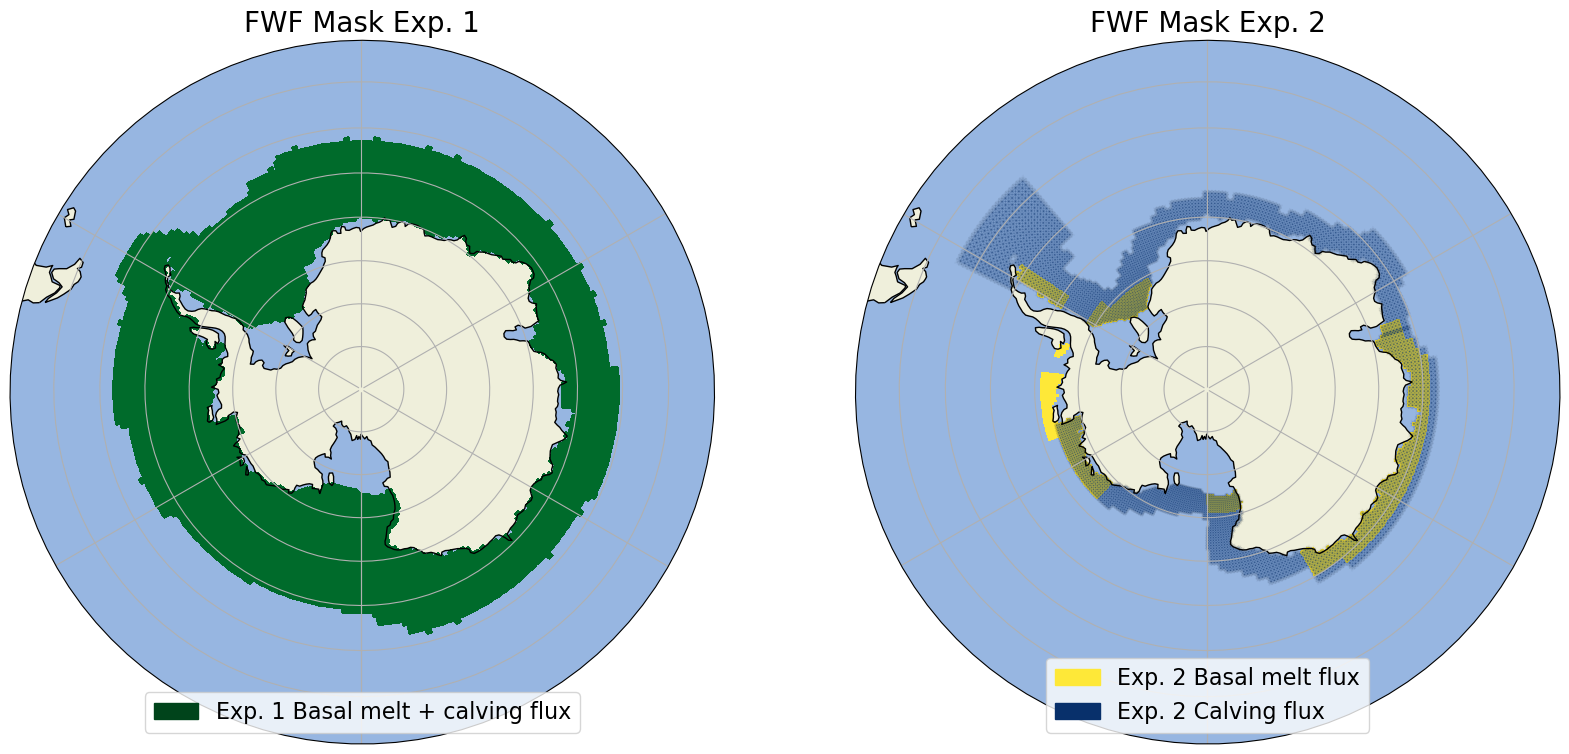

<Figure size 640x480 with 0 Axes>

In [6]:
'''
Making maps of the masks on which the forcing fluxes are applied for the 5icu (exp. 1) and lcic (exp. 2) runs
'''

import matplotlib.patches as mpatches
import matplotlib.cm as cm

fig, (ax1, ax2) = plt.subplots(1,2, figsize = [20,12], subplot_kw = dict(projection=ccrs.SouthPolarStereo()))
#fig.suptitle('Map of freshwater forcings around Antarctica', fontsize = 16)

#make circular instead of square plot by setting circular boundaries
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax1 = plt.subplot(1, 2, 1)
ax1.title.set_text('FWF Mask Exp. 1')
ax1.title.set_fontsize(20)

#Limit the map to -50 degrees latitude and below.
ax1.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax1.add_feature(cartopy.feature.LAND)
ax1.add_feature(cartopy.feature.OCEAN)
ax1.gridlines()
ax1.coastlines()

ax1.set_boundary(circle, transform=ax1.transAxes)

icu5_runoff_masked = np.ma.masked_array(fwf_5icu_total.mean('time_counter'), fwf_5icu_total.mean('time_counter') < 1e-5)
im3 = ax1.pcolormesh(fwf_5icu_ds.longitude, fwf_5icu_ds.latitude, icu5_runoff_masked,  
                    cmap = 'Greens',  alpha = 1, edgecolors = 'face', vmin = 0, vmax = 1.5e-5,
                    label = 'Exp. 1 Basal melt + calving flux',
                    transform=ccrs.PlateCarree())

ax2 = plt.subplot(1, 2, 2)
ax2.title.set_text('FWF Mask Exp. 2')
ax2.title.set_fontsize(20)
#Limit the map to -50 degrees latitude and below.
ax2.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND)
ax2.add_feature(cartopy.feature.OCEAN)
ax2.gridlines()
ax2.coastlines()

ax2.set_boundary(circle, transform=ax2.transAxes)

lcic_runoff_masked = np.ma.masked_array(fwf_lcic_ds.sorunoff_f.mean('time_counter'), fwf_lcic_ds.sorunoff_f.mean('time_counter') < 1e-5)
lcic_runoff_masked = lcic_runoff_masked.astype(int)
im2 = ax2.pcolormesh(fwf_lcic_ds.longitude, fwf_lcic_ds.latitude, lcic_runoff_masked,  
                    cmap = 'cividis_r', alpha = 1, shading = 'nearest', vmin = 0.9, vmax = 1.05,
                    label = 'Exp. 2 Basal melt flux',
                    transform=ccrs.PlateCarree())

lcic_calving_masked = np.ma.masked_array(fwf_lcic_ds.socalving_f.mean('time_counter'), fwf_lcic_ds.socalving_f.mean('time_counter') < 1e-5)
lcic_calving_masked = lcic_calving_masked.astype(int)
im1 = ax2.pcolormesh(fwf_lcic_ds.longitude, fwf_lcic_ds.latitude, lcic_calving_masked,  
                    cmap = 'Blues_r', alpha = 0.2, shading = 'gouraud', vmin = 0.9, vmax = 1.05,
                    label = 'Exp. 2 Calving flux',
                    transform=ccrs.PlateCarree())

# Legend for ax1
legend1_labels = ['Exp. 1 Basal melt + calving flux']
legend1_colormap = plt.colormaps.get_cmap('Greens_r')

legend1_handles = [mpatches.Patch(color=legend1_colormap(0), label=legend1_labels[0])]
legend1 = ax1.legend(handles=legend1_handles, loc='lower center', fontsize = 16)

# Legend for ax2
legend2_labels = ['Exp. 2 Basal melt flux', 'Exp. 2 Calving flux']
legend2_colormaps = [plt.colormaps.get_cmap('cividis_r'), plt.colormaps.get_cmap('Blues_r')]

legend2_handles = [mpatches.Patch(color=colormap(0), label=label) for colormap, label in zip(legend2_colormaps, legend2_labels)]
legend2 = ax2.legend(handles=legend2_handles, loc='lower center', fontsize = 16)

plt.show()
plt.clf()

In [7]:
#reading areacello data file and converting it to a xarray dataset
fn_aco = '/net/pc200037/nobackup/users/linden/cmip6data/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r1i1p1f1/Ofx/areacello/gn/areacello_Ofx_EC-Earth3_historical_r1i1p1f1_gn.nc'
aco = xr.open_dataset(fn_aco)

In [8]:
def gta_converter(dataset):
    dataset_gta = (((dataset)*(aco.areacello)).sum(['i','j']))*(31536000/1e12) 
    return dataset_gta

In [9]:
fwf_lcic_total_areaweighted_gta = gta_converter(fwf_lcic_total)
fwf_5icu_total_areaweighted_gta = gta_converter(fwf_5icu_total)

In [10]:
'''Reading in data from the CMIP6 model for friver, precipitation and evaporation variables.'''

#CMIP6
# historical friver
fn_friver_sd_hist = '/net/pc200037/nobackup/users/linden/cmip6data/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r1i1p1f1/Omon/friver/gn/*.nc'
friver_sd_hist = xr.open_mfdataset(fn_friver_sd_hist)

# ssp585 friver
fn_friver_sd_585 = '/net/pc200037/nobackup/users/linden/cmip6data/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3/ssp585/r1i1p1f1/Omon/friver/gn/*.nc'
friver_sd_585 = xr.open_mfdataset(fn_friver_sd_585)

# historical evspsbl
fn_evspsbl_sd_hist = '/net/pc200037/nobackup/users/linden/cmip6data/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r1i1p1f1/Amon/evspsbl/gr/*.nc'
evspsbl_sd_hist = xr.open_mfdataset(fn_evspsbl_sd_hist)

# historical pr
fn_pr_sd_hist = '/net/pc200037/nobackup/users/linden/cmip6data/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r1i1p1f1/Amon/pr/gr/*.nc'
pr_sd_hist = xr.open_mfdataset(fn_pr_sd_hist)

# ssp585 evspsbl
fn_evspsbl_sd_585 = '/net/pc200037/nobackup/users/linden/cmip6data/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3/ssp585/r1i1p1f1/Amon/evspsbl/gr/*.nc'
evspsbl_sd_585 = xr.open_mfdataset(fn_evspsbl_sd_585)

# ssp585 pr
fn_pr_sd_585 = '/net/pc200037/nobackup/users/linden/cmip6data/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3/ssp585/r1i1p1f1/Amon/pr/gr/*.nc'
pr_sd_585 = xr.open_mfdataset(fn_pr_sd_585)

#areacella
fn_aca = '/net/pc200037/nobackup/users/linden/cmip6data/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r5i1p1f1/fx/areacella/gr/areacella_fx_EC-Earth3_historical_r5i1p1f1_gr.nc'
aca = xr.open_dataset(fn_aca)

#land fraction (used to select data only on land)
#sftlf
fn_sftlf = '/usr/people/ijzerman/GradProject/DataFiles/sftlf.nc'
sftlf = xr.open_dataset(fn_sftlf)


In [11]:
def friver_processer(dataset):
    processed_dataset_var = ((dataset.friver*aco.areacello).isel(j=range(0,60,1))).sum(['i','j'])*(31536000/1e12)
    processed_dataset = processed_dataset_var.groupby('time.year').mean(dim='time') #making yearly means of friver
    processed_dataset['year'] = pd.to_datetime(processed_dataset['year'], format='%Y') + pd.to_timedelta('15D') #changing date format back to something useful
    return processed_dataset

In [12]:
friver_cmip6_hist_processed = friver_processer(friver_sd_hist)
friver_cmip6_585_processed = friver_processer(friver_sd_585)

fwf_cmip6 = xr.concat([friver_cmip6_hist_processed, friver_cmip6_585_processed], "year") #concatenating both datasets together over the time dimension

In [13]:
def prevap_processer(dataset_precip, dataset_evap):
    processed_dataset_var = ((((dataset_precip.pr - dataset_evap.evspsbl)*(sftlf.sftlf/100))*aca.areacella).isel(lat=range(0,48,1))).sum(['lat','lon'])*(31536000/1e12)
    processed_dataset = processed_dataset_var.groupby('time.year').mean(dim='time') #making yearly means of friver
    processed_dataset['year'] = pd.to_datetime(processed_dataset['year'], format='%Y') + pd.to_timedelta('15D') #changing date format back to something useful
    return processed_dataset

In [14]:
prevap_cmip6_hist = prevap_processer(pr_sd_hist, evspsbl_sd_hist)
prevap_cmip6_585 = prevap_processer(pr_sd_585, evspsbl_sd_585)

prevap_cmip6 = xr.concat([prevap_cmip6_hist, prevap_cmip6_585], "year") #concatenating both datasets together


In [15]:
import matplotlib.dates as mdates

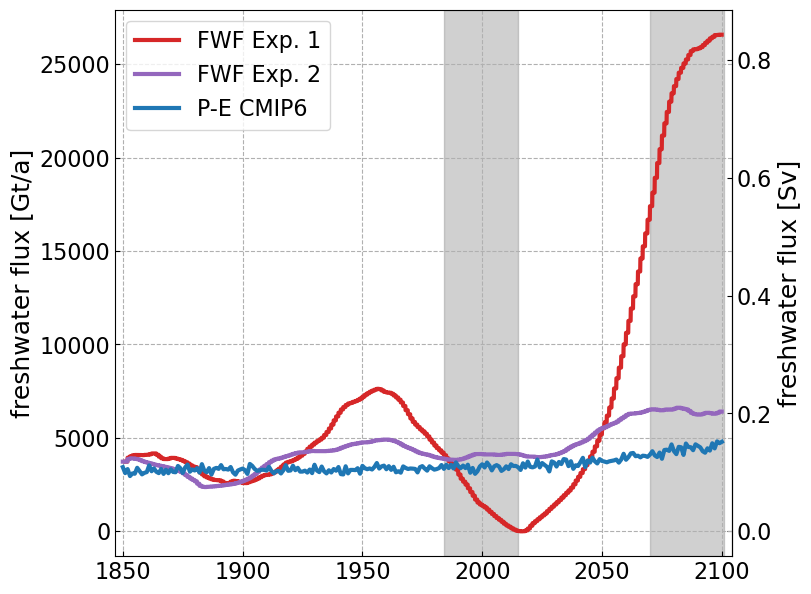

In [16]:
fig, ax1 = plt.subplots(figsize=[8,6])
#fig.suptitle('Fresh water forcing comparison for the two LRF implementations', fontsize = 16)

#ax1.set_xlabel('year', fontsize = 18)
ax1.set_ylabel('freshwater flux [Gt/a]', fontsize = 18)
ax1.set_xlim(-45000, 49000)
ax1.plot(fwf_5icu_total_areaweighted_gta.time_counter, fwf_5icu_total_areaweighted_gta, linewidth = 3, color = 'tab:red', label = 'FWF Exp. 1')
ax1.plot(fwf_lcic_total_areaweighted_gta.time_counter, fwf_lcic_total_areaweighted_gta, linewidth = 3, color = 'tab:purple', label = 'FWF Exp. 2')

secax_x = ax2.secondary_xaxis('bottom')
# ax1.plot(fwf_cmip6.year, fwf_cmip6, linewidth = 3, color = 'tab:blue', label = 'FWF CMIP6')
ax1.plot(prevap_cmip6.year, prevap_cmip6, linewidth = 3, color = 'tab:blue', label = 'P-E CMIP6') #color = '#26c21b'

def Gta_to_sverdrup(x):
    return (x * 1/31536)

def Sverdrup_to_Gta(x):
    return x * 31536

secax_y = ax1.secondary_yaxis('right', functions=(Gta_to_sverdrup, Sverdrup_to_Gta))
secax_y.set_ylabel('freshwater flux [Sv]', fontsize = 18)
secax_y.tick_params(direction = 'in', labelsize = 16)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
years = mdates.YearLocator(50)  # set the desired interval in years
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.axvspan(xmin = '1984-01-01', xmax = '2014-12-31', color = 'grey', alpha = 0.37)
plt.axvspan(xmin = '2070-01-01', xmax = '2100-12-31', color = 'grey', alpha = 0.37)
plt.tick_params(direction = 'in', labelsize = 16)
plt.grid(linestyle = '--')
plt.legend(fontsize = 16)
plt.show()